# Detecting Sarcasm in Reddit Comments for Content Moderation

**NOTE: This notebook is built to run on a local machine. For users who prefer to run the notebook here, please refer to `requirements.txt` in the repo for instructions on which dependencies to install.**

**If you would like to run this notebook in Google Colab, the link is [here](https://colab.research.google.com/drive/1EauMTYEtjHfG_TZ1CwBXgNXPr3njcdMW?usp=sharing) and in the Git repo under "Colab_notebook_link.md"**

# Introduction

For my final project, I am building a series of models with the goal of detecting sarcasm in a collection of Reddit comments. To achieve this, I am leveraging multiple Natural Language Processing (NLP) techniques, including different types of tokenization, vectorization, and word embeddings.

My modeling process features a wide range of methods, including Multinomial Naive Bayes, XGBoost, and two types of neural networks (multilayer perceptrons and long short-term memory).

The work all appears in this notebook, which includes instructions on data retrieval, preprocessing, and modeling, along with an option to import pre-trained model weights for quicker prediction results.

The processes required for this analysis can be broken down into 5 parts:

1. **Data Collection and Preparation**: Downloading the dataset and converting it into a format suitable for analysis.
2. **EDA**: Analyzing key metrics and getting a deeper understanding of the characteristics of our most important features.
3. **Preprocessing**: Tokenizing and cleaning the raw text before converting the vocabulary into numerical representations (vectors).
4. **Modeling**: Iteratively fitting different machine learning algorithms to our vectorized data and mapping the results.
5. **Evaluation and Conclusion**: Discussing the performance of our models and forming recommendations baed on results.

**Sample Image:**

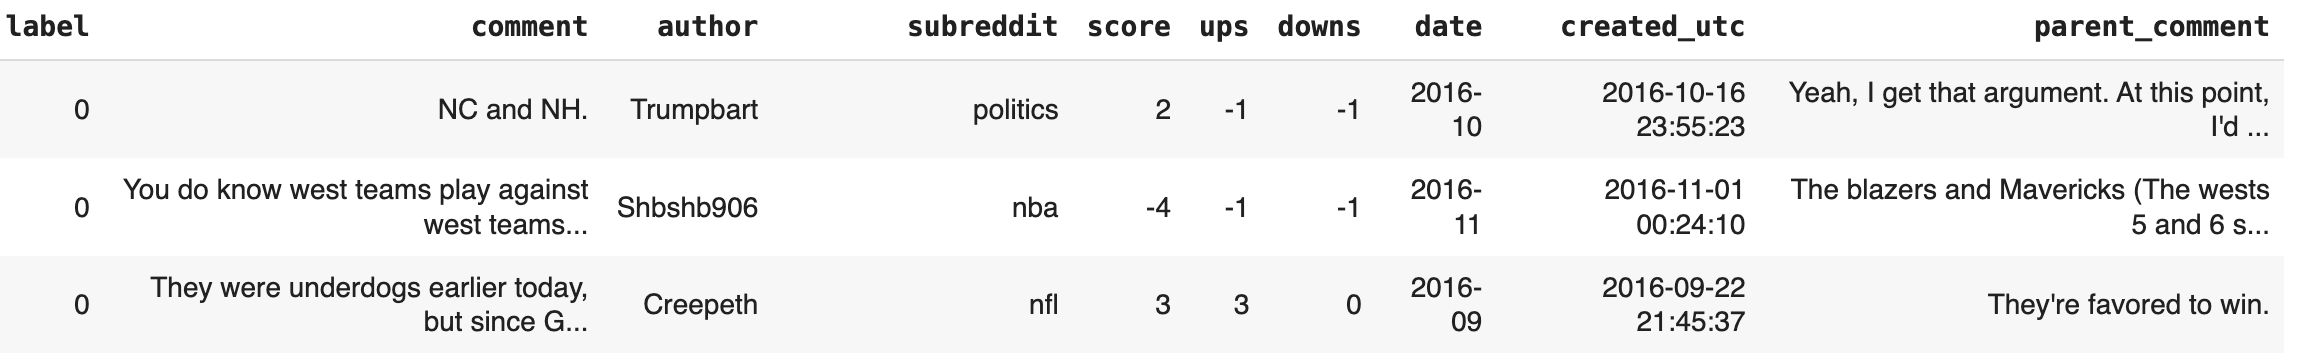

# Objectives

The objectives of this project are:
1. To see whether there are differences in the vocabulary of sarcastic responses vs. serious ones.
2. To extract features from the raw text that capture some degree of context.
3. Model the extracted features and assess how results could be improved.

# Business Case

<img src = 'https://m.media-amazon.com/images/I/A13usaonutL._CLa%7C2140%2C2000%7C71n5YfKHmgL.png%7C0%2C0%2C2140%2C2000%2B0.0%2C0.0%2C2140.0%2C2000.0_AC_UY1000_.png' width='400px' height='400px'>

Sarcasm presents a unique linguistic challenge. Heavily reliant on context and inherently ambiguous, sarcasm is used in different ways across many cultures. Despite its everyday use in conversation, it can be difficult to detect in text. This is because we often need to see and hear someone say something to understand whether they are serious or not. We subconsciously notice tiny changes in tone, facial expression, and even body language to make our decision. When reading, we don't have that luxury. Without underlying contextual and tonal clues, a message that is meant to be sarcastic often does not vary widely from a sentence where the meaning is meant to be taken literally.

Being able to effectively detect sarcasm has, until very recently, been a distinctly human endeavor. This project aims to take a step forward in changing that. **With the use of various NLP techniques, we can attempt to capture some underlying context from Reddit comments that display sarcasm and learn to predict it better.**

With the understanding that sarcasm detection can be extremely difficult for computers, **I would propose the deployment of our final model for content moderation and bullying detection on Reddit in concert with humans.** Given that much content moderation is still manual, even an imperfect model could lessen the load for human moderators by tagging messages as sarcastic. Given that many sarcastic messages can be intentionally humorous but would be offensive or concerning if taken seriously, this is a valuable service to provide at scale.

**Reddit could leverage this technology in many ways. Specifically, they could use it to enforce punishments for inappropriate language, detect bullying, or better recommend certain content to people who tend to interact with or publish more sarcastic content. This could improve the user experience on the app and increase general satisfaction, as well as making Reddit a safer place for everyone.**

Given that sarcasm is often also humorous, automated moderation and detection has a wide range of applications and could someday be used across multiple social platforms. This project can serve as a pilot with a relatively small sample size to see if sarcasm detection with different models is feasible at a larger scale.



# Data Understanding

Our data is sourced from this [Kaggle dataset](https://www.kaggle.com/datasets/sherinclaudia/sarcastic-comments-on-reddit/data). According to the user who publised it, the dataset was created by scraping comments from Reddit, many of which included the '/s' tag, a tag commonly used to denote sarcasm. The owner of the dataset notes that "This tag is often used by Redditors to indicate that their comment is in jest and not meant to be taken seriously, and is generally a reliable indicator of sarcastic comment content."

The data consists of 1.3 million rows of Reddit comments, manually assigned labels of 1 or 0 (sarcastic or not sarcastic). The dataset also includes more information on each comment, including the subreddit it was posted on, the number of upvotes or downvotes, and the "parent comment"-- the post that the labeled comment was responding to.

The creators also offered a balanced version of the dataset, which has an equal number of sarcastic and non-sarcastic comments but features about 300,000 fewer rows. I opted for this version because it saves some resampling steps during preprocessing. For the purposes of this project, many of the additional columns were discarded and we primarily focus on the primary comments.

For this analysis, the target metrics are:
- **Recall:** For our purposes, we of course want to maximize the instances of sarcasm (or non-sarcasm) that our models can detect. Ideally, we want recall for both negative and positive cases to be high, but the more important of the two would be recall for the **positive case**, meaning that we capture a high number of sarcastic comments.
- **Accuracy:** This is a much more general statistic for model performance, so it acts as a good becnhmark for overall quality as we iterate.

## Limitations

For our dataset, one specific limitation sticks out:

- **Inconsistent labeling.** This especially applies to the non-sarcastic or "negative" category. While the sarcastic comments were specifically tagged (making them more accurate), manual inspection of some of the data has yielded many comments labeled non-sarcastic that, in my opinion, should be labeled as sarcastic. This kind of labeling is highly subjective, and, because the labels are vital to model training, inconsistency can throw off its ability to predict accurately.

Beyond that, datasets scraped from social media can have several limitations preparation and modeling in general:

- **They can be "messy".** Not just in terms of punctuation and grammar (which can be cleaned away), but there also is a myriad of slang, profanity, abbreviations, and words that are extremely specific to a certain context-- the name of a video game character or ability, for example. When we are looking to understand patterns and context, these can serve as limiting factors.
- **They can be too short.** The Reddit comments we are dealing with are often responses to another comment, and therefore are often fairly short, many with only a handful of words and some with just one or two. When we are looking for sarcasm, this can be challenging for a model to understand.


**Disclaimer: This data is from the internet and contains profanity and other inappropriate language.**

# EDA and Preprocessing (Time to Run: ~6 Minutes)

Let's begin by getting set up and taking a good look at the data we're working with. We can also use this as an opportunity to load all the libraries we will be working with during the project.

This is quite a few libraries. If you do not have certain ones installed, you will get an error. You can remedy this by using "pip install (library)" in your terminal before importing it. **As a reminder, `requirements.txt` has a full list of all the dependencies you need as well.**

In [77]:
# Import relevant libraries (this may take a minute or two)

# File and path manipulation
import joblib
import os, shutil
import json
from tensorflow.keras.models import load_model
from joblib import load
from joblib import dump
from IPython.display import FileLinks
from xgboost import Booster
import booster

# Data manipulation
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Language manipulation
import nltk
from nltk import bigrams, trigrams, ngrams
from nltk.probability import FreqDist
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import string
import re
from collections import defaultdict
nltk.download('stopwords', quiet=True) # Prevents message from being displayed if package already exists
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('vader_lexicon', quiet=True)

# Vectorization, modeling, and evaluation
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import learning_curve

# Word2Vec
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

# Neural Networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Embedding, Dropout, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.utils import plot_model

# Foundational model training
!pip install transformers --quiet
import torch
from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from torch.utils.data import Dataset

# For consistent randomness
import random

# For warnings
import warnings
warnings.filterwarnings('ignore') # Ignores warning messages

os.environ['KMP_DUPLICATE_LIB_OK']='True' # Tells system that duplicate libraries are allowed
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Prevents TensorFlow warning and info messages

Now we can load in our data as a DataFrame. For the model weights, we will load them in as we go during the modeling process.

In [78]:
# Load dataset as DataFrame
df = pd.read_csv('data/train-balanced-sarcasm.csv')
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [79]:
# Get DataFrame info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


We can see there are some missing values in the "comment" column, so we will need to remedy that. Otherwise, the data looks fairly clean given its size. We will take a closer look at the text itself during preprocessing.

In [80]:
# Getting null count for comparison
df['comment'].isna().sum()

53

In [81]:
# Dropping null rows and confirming new count
df.dropna(subset=['comment'], inplace=True)
df['comment'].isna().sum()

0

In [82]:
# Renaming "label" column to "target"
df = df.rename(columns={'label' : 'target'})
df.tail()

,target,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...
1010825,1,"values, as in capitalism .. there is good mone...",frogking,politics,2,2,0,2009-01,2009-01-24 06:20:14,Why do the people who make our laws seem unabl...


To give us a better sense of where our comments are coming from, let's make a chart of the most frequently-occuring subreddits in our data:

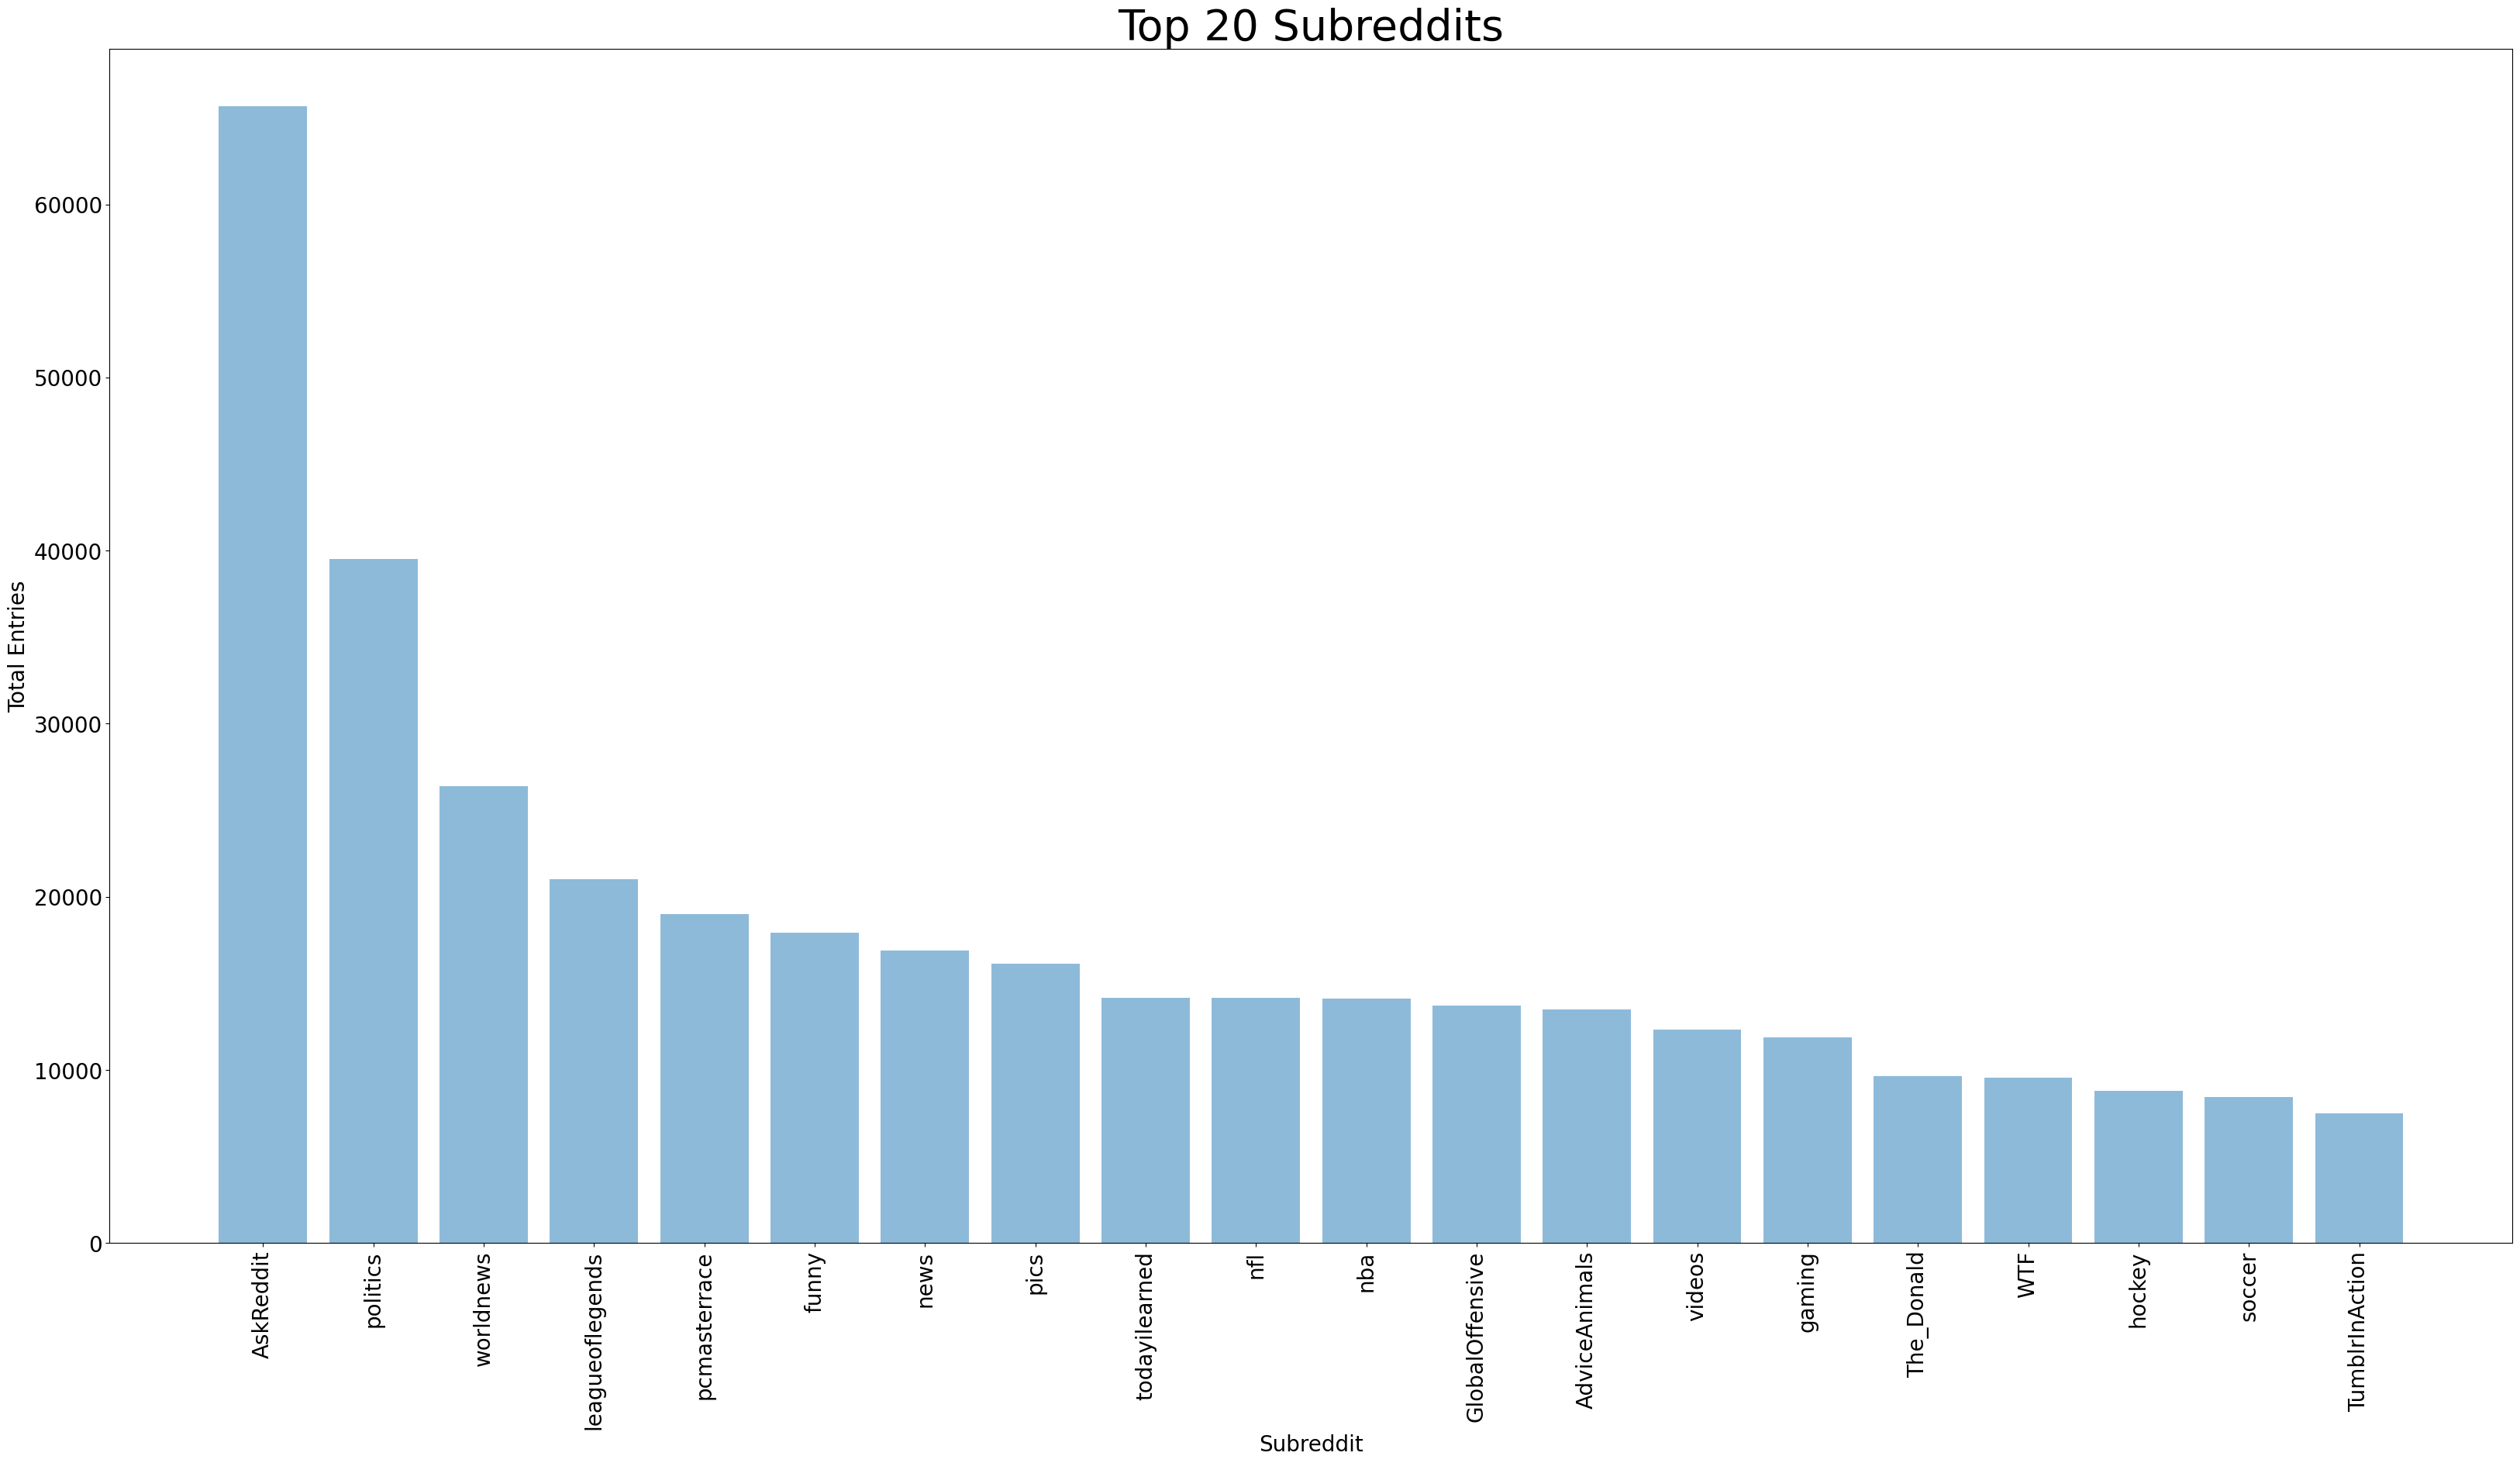

In [83]:
# Get a list of the top 20 subreddits
subreddit_counts = pd.DataFrame(df['subreddit'].value_counts()[:20])

# Plot a chart of the top subreddits
fig, ax = plt.subplots()
fig.set_size_inches(40, 20)
plt.xticks(fontsize=20, rotation=90)
plt.bar(list(subreddit_counts.index), list(subreddit_counts.subreddit), align='center', alpha=0.5)
plt.xlabel('Subreddit', fontsize=20)
plt.ylabel('Total Entries', fontsize=20)
plt.yticks(fontsize=20)
ax.set_title("Top 20 Subreddits", fontsize=40)

plt.show()

As we can see, the comments in our dataset some from an extremely wide range of subreddits. r/AskReddit leads the pack by a large margin with over 60,000 comments hailing from there. r/politics comes in second but by a large margin. We see news, gaming, and sports subreddits take some spots as well, but most of these have 10,000 or less entries in the dataset. Showcasing the beauty and challenges of analyzing social media, this chart demonstrates the profound diversity of topics, context, and language we will see in this dataset.  

Now, let's get an example of a random normal comment and a random sarcastic comment, just to get a sense of what we are working with.

Feel free to run the function until you get comments that make sense to you-- the dataset draws from a wide range of subjects.

In [84]:
# Splitting into separate dataframes
normal_df = df[df['target'] == 0]
sarcastic_df = df[df['target'] == 1]

In [85]:
# Function to retrieve random normal comment
def get_normal_comment(index):

    '''This function selects a random row from the non-sarcastic dataframe and prints the comment,
        the parent comment, and the subreddit it came from.'''

    topic = normal_df.iloc[index].subreddit
    parent_comment = normal_df.iloc[index].parent_comment
    comment = normal_df.iloc[index].comment


    print(f'''Topic: {topic}\nParent Comment: {parent_comment}\nComment: {comment}''')

get_normal_comment(random.randint(0, len(normal_df)))

Topic: Smite
Parent Comment: Why is Ares a guardian? Seriously... Shouldn't the Greek God of war PROBABLY be a WARrior? Him being a guardian seems so silly to me. Also, why, in a pantheon of conflict and war like the Greeks, does there not exist a single warrior? Really, Hi Rez? REALLY? Also, having both the Greek and Roman pantheon kind of sucks because there is so much overlap. Everyone has an equivalent. I.e. mercury/Hermes Poseidon/Neptune hephausteus/vulcan.
Comment: It's also funny when a Guardian says "A warrior's death..."


In [86]:
# Function to retrieve random sarcastic comment
def get_sarcastic_comment(index):

    '''This function selects a random row from the sarcastic dataframe and prints the comment,
        the parent comment, and the subreddit it came from.'''

    topic = sarcastic_df.iloc[index].subreddit
    parent_comment = sarcastic_df.iloc[index].parent_comment
    comment = sarcastic_df.iloc[index].comment


    print(f'''Topic: {topic}\nParent Comment: {parent_comment}\nComment: {comment}''')

get_sarcastic_comment(random.randint(0, len(sarcastic_df)))

Topic: AskReddit
Parent Comment: Heroin. I just sat back while all my friends died or got hauled off to prison.
Comment: Good job not doing heroin


If you use the generator a few times for each category, you can get a very general sense of what these comments actually look like. Their subject, length, spelling, punctuation, and grammar are incredibly varied. This will introduce further complications to our modeling process, which seeks to pick up context and trends where they may not exist.

To further explore how sarcastic comments differ from serious ones, we can create a simple visualization to illustrate the most common words from each respective dataframe:

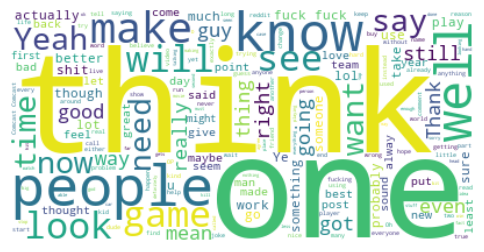

In [11]:
# Create a wordcloud of the most common words from the normal dataframe
text_df = ' '.join([str(text) for text in normal_df['comment']])
wordcloud = WordCloud(background_color="white").generate(text_df)

# Display the generated image:
plt.figure(figsize=(6, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

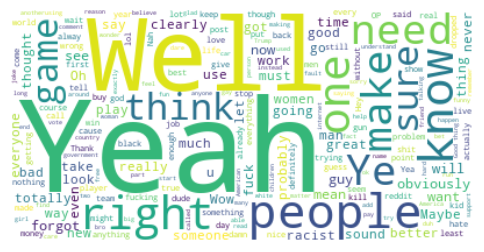

In [12]:
# Create a wordcloud of the most common words from the sarcastic dataframe
text_df = ' '.join([str(text) for text in sarcastic_df['comment']])
wordcloud = WordCloud(background_color="white").generate(text_df)

# Display the generated image:
plt.figure(figsize=(6, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

While the changes may appear subtle, we can actually see the distinct shift in language when a comment gets more sarcastic. While the largest words in the non-sarcastic wordcloud appear more distinct ("think", "know", "people", "one"), the top words in the sarcastic wordcloud generally convey a more confrontational tone ("yeah", "well", "sure", "right").

As English speakers, we can actually assign a tone to this sarcastic wordcloud in our heads. You can imagine someone responding "Yeah, sure," in a sarcastic voice. That tone shift could be what this wordcloud is representing. The comments in this category will rarely appear sarcastic on the page, without that inner dialogue that assigns a tone. Context will be very important in this project and should be considered as we move through our modeling process later on.

## Preprocessing

![Preprocessing Steps Image](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*pt47uCcCn3X7XNYQg1dghw.png)

We will now begin to process our data before we can feed it into our various models.

Preparing natural language for evaluation is a multi-step process. We start with our corpus, which in this case would be the text of the "comment" column. To begin, we have to tokenize each comment-- in other words, split a large cluster of words into smaller parts, or "tokens". Today, we will be working with unigrams, bigrams, and trigrams. That means we are tokenizing the raw text into groups of one, two, and three words. Since we are doing our best to filter out words or groups of words that appear a vanishing amount of times in the corpus as a whole, we will only see a few common bigrams and even fewer trigrams.

Next, we need to clean the tokenized text. This involves removing stopwords (commonly used words with low semantic value), removing punctuation and capitalization, and reducing the words to their root (otherwise known as stemming or lemmatizing).

Finally, we can move onto vectorization. This process creates a numerical representation of each word in the tokenized "vocabulary". This not only structures the data in a way that is more advantageous for modeling, but also allows us to extract more semantic meaning and context from the data during modeling.

There are many different ways to vectorize, and we will be using two different forms in this project: Term Frequency — Inverse Document Frequency (TF-IDF) and Word2Vec.

To avoid data leakage, we will perform our train/validation/test split before our cleaning steps. This will ensure that each subset is processed separately.

Once everything is tokenized, cleaned, and vectorized, we can also convert our subsets into lists and arrays so they will be compatible with some of the model types we are using.

**NOTE: By default, I am using the whole dataset. If you would like to run faster and more lightweight models or test different strategies, uncomment the sample_df blocks below.**

In [13]:
# Create a sample dataset with n samples from each category
# n = 10000 # Set to number of your choosing
# if n > len(df)/2:
  # print('That number is too large! Please select a valid sample size')
# "sample_df = df.groupby('target').apply(lambda x: x.sample(n=10, random_state=42)).reset_index(drop=True)

In [14]:
# sample_df['target'].value_counts()

In [15]:
# sampled_df.head()

In [16]:
# Define X and y
y = df['target']
X = df['comment']

In [17]:
# Perform initial split for train set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [18]:
# Perform split on X_temp to get validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)

In [19]:
# Preview X_train
X_train

693053    The science is clearly WRONG and I am FURIOUS ...
80767                                               If only
811805                       As much as Hindus in Pakistan?
990726    Bullshit, everyone knows that all PC games loo...
68296                               Wow what a darkhorse...
                                ...                        
259183                                           Pirate it!
365850                My state does the on call judges too.
131934                                Temporal displacement
671178    God it's like people who idolize Tony Montana ...
121960                                                   :(
Name: comment, Length: 707541, dtype: object

In [20]:
# Print length of X_train and y_train
print(len(X_train), len(y_train))

707541 707541


We now have our train, validation and test sets. However, they are still made up of raw, un-modelable text. To preview our processing steps, let's grab a sample comment and take it through the whole process up to vectorization:

In [21]:
# Grab the first row from X_train
sample_text = X_train.iloc[0]

stops = stopwords.words('english') # Assign stopwords variable
pattern = "([a-zA-Z]+(?:'[a-z]+)?|\b\d+[\w'-]*)" # Assign Regex pattern

tokenizer = RegexpTokenizer(pattern=pattern) # Instantiate tokenizer
test = tokenizer.tokenize(sample_text) # Tokenize sample

new_text = [word.lower() for word in test if word.lower() not in stops] # Remove capitalization

lemmatizer = nltk.stem.WordNetLemmatizer() # Instantiate lemmatizer

final_text = [lemmatizer.lemmatize(word) for word in new_text] # Lemmatize text

print(sample_text)
print('')
' '.join(final_text)

The science is clearly WRONG and I am FURIOUS about it!



'science clearly wrong furious'

As you can see, we have whittled down this comment to its base components, removing punction, capitalization, suffixes, and common words. This is what all of our rows will look like before we vectorize them.

If you're curious about what qualify as stopwords, here is an example of some below:

In [22]:
# Get first 10 stopwords
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

Let's make that cleanup process into a function that we can easily call on all our subsets:

In [23]:
def cleanup(comment):

    '''This function defines stopwords and a regex pattern, tokenizes a raw text input, removes punctuation,
        removes caps, and lemmatizes. It returns a string of cleaned words.'''

    stops = stopwords.words('english')
    token_pattern = "([a-zA-Z]+(?:'[a-zA-Z]+)?|\b\d+[\w'-]*)"

    tokenizer = RegexpTokenizer(pattern=token_pattern)
    lemmatizer = nltk.stem.WordNetLemmatizer()

    tokenized_text = tokenizer.tokenize(comment)

    lowercase_text = [word.lower() for word in tokenized_text if word.lower() not in stops]

    lemmatized_text = [lemmatizer.lemmatize(word) for word in lowercase_text]

    return ' '.join(lemmatized_text)

In [24]:
cleaned_comments_train = [cleanup(comment) for comment in X_train]

cleaned_comments_val = [cleanup(comment) for comment in X_val]

cleaned_comments_test = [cleanup(comment) for comment in X_test]

In [25]:
cleaned_comments_train

['science clearly wrong furious',
 '',
 'much hindu pakistan',
 'bullshit everyone know pc game look better console trash regardless system spec',
 'wow darkhorse',
 'secret u',
 'fat pink mast',
 'man ussr shit alexander solzhenitsyn told tsar awesome',
 'oh come need bethenny kim cage match',
 'went kt cj clearly got worse',
 'good go',
 "maybe position evolved like hillary's lgbt stance couple year back",
 'omg u misogynist',
 'title wrong got game ban griefing however simply assume got csgo vac banned cheater cheater',
 'sense talk coming',
 'guy play lottery instead worrying bounty',
 "lie that's wood wrap hana cana",
 'yeah shoulda killed people',
 "nah they're dissing pobelter",
 "le da's be's di's",
 'idea going',
 'look like',
 'serbian flag didnt see one coming',
 'ok clever',
 'right european never bomb school child',
 'hence asking told called',
 "cuz got vac banned mean he's cheater",
 'oh god microsoft pay youtube server',
 'clearly cause microsoft innovative apple copy',

Now, we can put the raw text into our vectorizer:

In [26]:
vectorizer = TfidfVectorizer(token_pattern="([a-zA-Z]+[’']?[a-zA-Z]*|\b\d+[\w'-]*)",
                             ngram_range=(1, 3),
                             min_df = 0.001, # Text must appear in at least .01% of examples
                             max_df=1.0)

In [27]:
X_train_vecs = vectorizer.fit_transform(cleaned_comments_train)
X_val_vecs = vectorizer.transform(cleaned_comments_val)
X_test_vecs = vectorizer.transform(cleaned_comments_test)

In [28]:
X_train_dense = X_train_vecs.toarray()
X_val_dense = X_val_vecs.toarray()
X_test_dense = X_test_vecs.toarray()

df_X_train_vecs = pd.DataFrame(X_train_dense, columns=vectorizer.get_feature_names_out())

In [29]:
df_X_train_vecs

,ability,able,absolutely,account,act,action,actual,actually,ad,add,...,yeah that's,year,year ago,year old,yep,yes,yet,young,youtube,yup
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
707537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
707538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
707539,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Great! We have formed a vocabulary of 908 words (or groups of words) for our training set. This vectorizer assigns vectors based not just on how commonly a word appears in a given entry, but also factors in how frequently that word appears in the entire corpus. This creates a weighted score that gives us a better sense of a given word's importance in a comment. You can see a sorted list below:

In [30]:
# Create a DataFrame with TF-IDF scores
tfidf_sum = X_train_vecs.sum(axis=0)

# Calculate the average score for each n-gram.
tfidf_avg = tfidf_sum / X_train_vecs.shape[0]  # Divide by the number of documents

# Create a DataFrame with n-grams and their average scores.
tfidf_avg_df = pd.DataFrame(tfidf_avg.T, index=vectorizer.get_feature_names_out(), columns=['avg_score'])

# Sort the DataFrame by the average score in descending order.
tfidf_avg_df = tfidf_avg_df.sort_values(by='avg_score', ascending=False).reset_index()
tfidf_avg_df.rename(columns={'index': 'ngram'}, inplace=True)

tfidf_avg_df

,ngram,avg_score
0,like,0.018564
1,yeah,0.015485
2,get,0.014164
3,would,0.012474
4,one,0.012431
...,...,...
903,year ago,0.000507
904,would never,0.000506
905,i'm glad,0.000498
906,last year,0.000496


Here are the most common unigrams and bigrams in X_train:

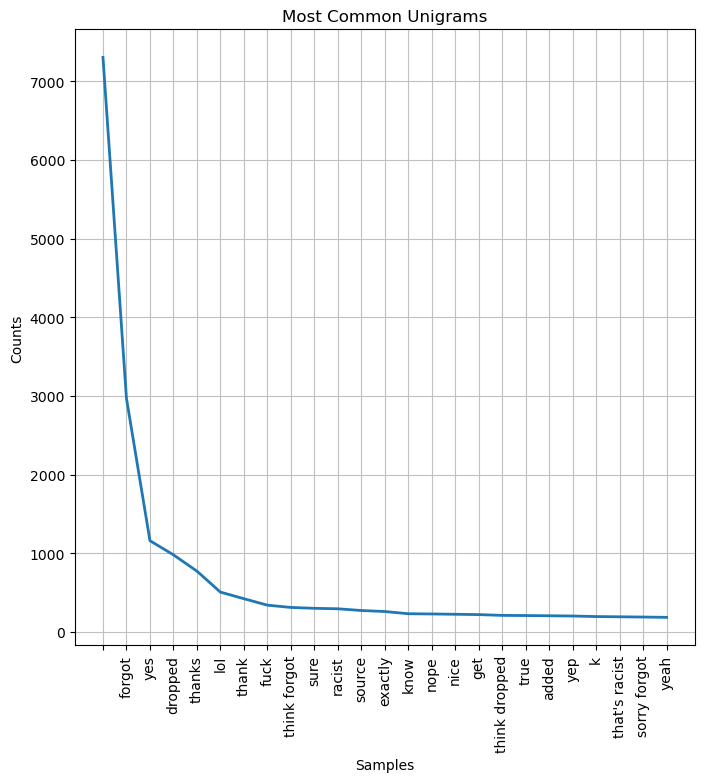

<AxesSubplot:title={'center':'Most Common Unigrams'}, xlabel='Samples', ylabel='Counts'>

In [31]:
# Create a frequency distribution of tokenized text
unigrams = FreqDist(cleaned_comments_train)

# Plot distribution of top 25 unigrams
plt.figure(figsize=(8, 8))
plt.title('Most Common Unigrams')
unigrams.plot(25)

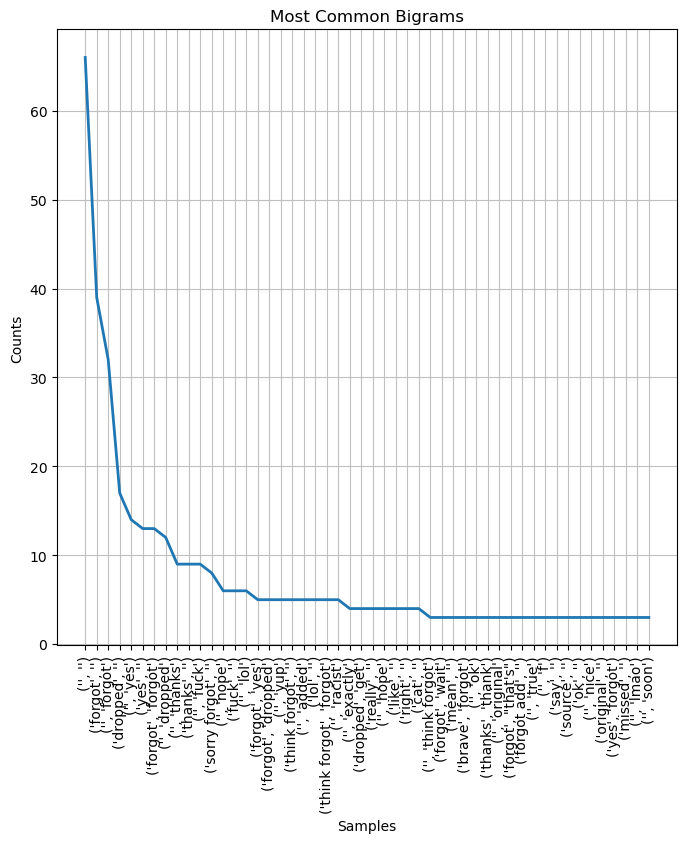

<AxesSubplot:title={'center':'Most Common Bigrams'}, xlabel='Samples', ylabel='Counts'>

In [32]:
# Create a frequency distribution from tokenized text
bigrams = FreqDist(ngrams(cleaned_comments_train, 2))

# Plot distribution of top 50 bigrams
plt.figure(figsize=(8, 8))
plt.title('Most Common Bigrams')
bigrams.plot(50)

# Modeling (Time to Run: ~4 Minutes)

Our modeling process consists of four iterationns. We employ four different learning methods (Multinomial Naive Bayes, XGBoost, Multi-Layer Perceptron and Recurrent Neural Network using Long Short-Term Memory). Below is a breakdown of how each model works and why each makes sense for our business objectives:

**Multinomial Naive Bayes:** This classifier works by assuming that each of our words (or ngrams) are independent of each other. It figures out which comments are sarcastic or not by calculating the prior probability of sarcasm given the frequency of words in each class. This may not be the most accurate or most effective for our purposes because sarcasm requires a model to pick up subtle nuances and context that MNB may not recognize. However, these models are effective because they are lightweight and lightning-fast to train, predict, and store.

**XGBoost:** An optimized and faster version of the gradient-boosting algorithm, this model relies on lots of decision trees and uses a voting mechanism to decide on a classification for each comment. These types of models can be good at analyzing noisy data and understanding feature interactions, which will be good for us given the fact that our vocabulary is quite diverse and would only get largr if these models were increased in size and deployed sitewide. It also can handle outliers and class imbalances quite well. These attributes will also be vital when dealing with very large vocabularies of extremely varied and imbalanced content. This version is also compatible with GPUs, enabling parallel processing for exponentially faster training.

**Multi-Layer Perceptron:** MLPs are a common type of neural network that can be used for many types of classification. Our model consists of an input layer (where our text vectors go) and two "hidden layers", or middle layers of interconnected neurons that receive numbers, perform calculations, squish the outputs between 0 and 1 (or -1 and 1) and feed them forward to the next layer. Our output layer is where our final predictions are made, and we get one number that acts as a sarcasm label. While these models are quite complex, take longer to train and are difficult to analyze, they can automatically pick up a lot more nuances and non-linear transformations from the vectors. They can also effectively detect important features and improve on themselves via backpropagation and built-in evaluation on validation data.

**Reccurent Neural Network:** While some types of neural networks (like Convolutional Neural Networks) are more suited for image data, RNNs are specifically suited for text data. This is because they process text sequentially. The way that these models continuously update their hidden states essentially allows them to process longer sequences of text, meaning that they can pick up on longer context and patterns, making them potentially the most effective at classifying something as tricky as sarcasm. [This paper](https://arxiv.org/abs/1912.05911) from Robin Schmidt lays out the mechanics for how this works. The middle step for RNNs works differently from a traditional neural network, as the RNN recursively works to update its hidden layer during that middle step.

This forms a different learning cycle where, essentially, each iteration of the hidden layer is not just receiving information from each new input, but also from each previous hidden layer. That makes the output of each cycle an amalgamation of the current input and multiple past inputs. This is what makes RNNs more suitable for situations like ours, where the context of past words is important.

The one drawback for our purposes is that they require lots of compute and time to train. On a much larger vocabulary, training could take days or weeks for optimal performance.

**NOTE: Do not un-comment the commented blocks unless you want to train your own models! This process can take hours.**

**Loaded weights may produce different results over time given randomized train and validation data.**

## Naive Bayes and XGBoost

In [33]:
print(X_train_dense.shape)
print(X_val_dense.shape)

(707541, 908)
(151616, 908)


In [34]:
# mnb = MultinomialNB()

In [35]:
# mnb_model = mnb.fit(X_train_dense, y_train)

In [36]:
# baseline_y_hat = mnb_model.predict(X_val_dense)
# print(classification_report(y_val, baseline_y_hat))

In [37]:
# Save the model for future use
# joblib.dump(mnb_model, f'{model_directory}/mnb_model.joblib')

In [38]:
# Load the model
mnb_model_loaded = joblib.load('model-weights/mnb_model.joblib')

In [39]:
# Run predictions with loaded model and print report
mnb_y_hat = mnb_model_loaded.predict(X_val_dense)
print(classification_report(y_val, mnb_y_hat))

              precision    recall  f1-score   support

           0       0.62      0.74      0.67     75587
           1       0.68      0.55      0.61     76029

    accuracy                           0.64    151616
   macro avg       0.65      0.64      0.64    151616
weighted avg       0.65      0.64      0.64    151616



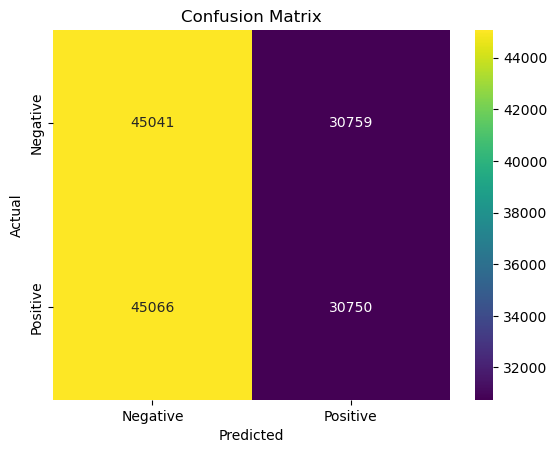

In [40]:
# Make confusion matrix
cm_mnb = confusion_matrix(y_test, mnb_y_hat)

# Plot confusion matrix on a Seaborn heatmap
sns.heatmap(cm_mnb, annot=True, fmt='d', cmap='viridis', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

What we see here is an accuracy of 64% and mediocre predictions across the board. In other words, we don't see any areas where the model is significantly overperforming or underperforming. Everything is sort of even. We can see this in our confusion matrix, as we have an almost equal number of false positives and negatives to true positives and negatives. We do see a higher recall for class 0. Given that we really want to be able to detect sarcasm when it's there, this is an area we really want to improve on.

Let's see how our next model performs. For this one, I have created a custom cleaning function so I can make a pipeline that includes all preprocessing and modeling steps:

In [41]:
# Create custom cleanup class for pipeline use
class Cleaner(BaseEstimator, TransformerMixin):

    '''This class defines a fit, transform, and cleanup method that will be able to fit a dataset
        and apply steps from the cleanup function above'''

    def fit(self, X, y=None): # Enables fit method
        return self

    def transform(self, X, y=None): # Enables transform method
        return [self.cleanup(comment) for comment in X]  # Applies cleanup function

    def cleanup(self, comment):

        # Cleans text
        stops = stopwords.words('english')
        token_pattern = "([a-zA-Z]+(?:'[a-zA-Z]+)?|\b\d+[\w'-]*)"

        tokenizer = RegexpTokenizer(pattern=token_pattern)
        lemmatizer = nltk.stem.WordNetLemmatizer()

        tokenized_text = tokenizer.tokenize(comment)

        lowercase_text = [word.lower() for word in tokenized_text if word.lower() not in stops]

        lemmatized_text = [lemmatizer.lemmatize(word) for word in lowercase_text]

        cleaned_comment = ' '.join(lemmatized_text)

        return cleaned_comment

In [42]:
# Create XGB Pipeline
# xgb_pipe = Pipeline([('cleaner', Cleaner()),
#                   ('vectorizer', TfidfVectorizer(token_pattern="([a-zA-Z]+[’']?[a-zA-Z]*|\b\d+[\w'-]*)",
#                             ngram_range=(1, 3),
#                             min_df = 0.001,
#                            max_df=1.0)),
#                   ('clf', XGBClassifier(n_estimators=100,))
#])

In [43]:
# Fit model
#xgb_model = xgb_pipe.fit(X_train, y_train)

In [44]:
# Predict on val data and print classification report
# xgb_y_hat = xgb_pipe.predict(X_val)
# print(classification_report(y_val, xgb_y_hat))

In [45]:
# Save model
# Define the directory for saving the models
# model_directory = "model-weights"
# if not os.path.exists(model_directory):
#    os.makedirs(model_directory)

# Paths for the files
# xgb_model_path = os.path.join(model_directory, 'xgb_model.json')
# pipeline_path = os.path.join(model_directory, 'preprocessing_pipe.joblib')

# Save the XGBoost model
# xgb_model['clf'].get_booster().save_model(xgb_model_path)

# Save the rest of the pipeline
# dump(pipeline_without_xgb, pipeline_path)

In [46]:
# Load saved model

# Define file paths
model_directory = "model-weights"
xgb_model_path = os.path.join(model_directory, 'xgb_model.json')
pipeline_path = os.path.join(model_directory, 'preprocessing_pipe.joblib')

# Load the non-XGBoost parts of the pipeline
preprocessing_pipe = load(pipeline_path)

# Load the XGBoost model
xgb_clf = XGBClassifier()  # Create a new XGBClassifier
xgb_clf.load_model(xgb_model_path)  # Load the model

# Construct the full pipeline
full_pipeline = Pipeline(steps=[
    *preprocessing_pipe.steps,
    ('clf', xgb_clf)
])

In [47]:
# Get predictions
xgb_y_hat = full_pipeline.predict(X_val)
print(classification_report(y_val, xgb_y_hat))

              precision    recall  f1-score   support

           0       0.61      0.81      0.70     75587
           1       0.72      0.48      0.58     76029

    accuracy                           0.65    151616
   macro avg       0.67      0.65      0.64    151616
weighted avg       0.67      0.65      0.64    151616



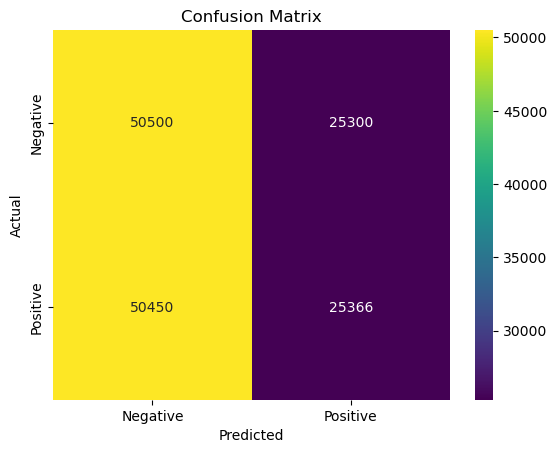

In [48]:
# Create confusion matrix
cm_xgb = confusion_matrix(y_test, xgb_y_hat)

# Plot confusion matrix
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='viridis', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

It seems that this model has gone backwards in some ways and forwards in others. However, our precision and recall values are far more skewed in interesting directions. With a higher precision on sarcastic comments, this means that if our model predicts a model is sarcastic, it has a higher likelihood of being correct than it did before. With a very high recall for non-sarcastic comments, we see that this model is quite good at identifying serious comments across the test data. This is interesting, because we have produced something that is very good at telling us what isn't sarcastic, but that is terrible at telling us what is sarcastic. The ROC/AUC curve below confirms the our middling recall performance.

It will be interesting to see how this performance evolves as our models get more complex and attuned to more intricate features in the data.

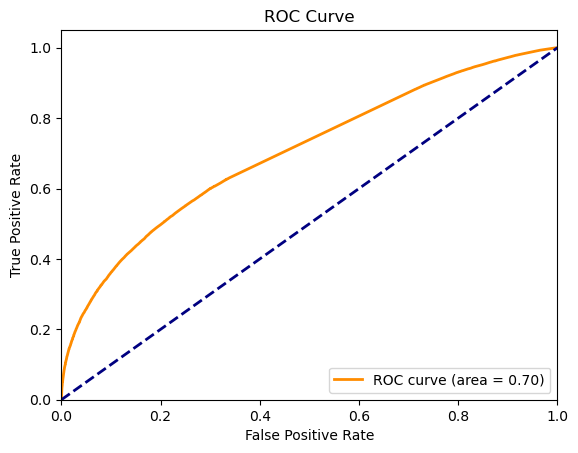

In [49]:
# Generate ROC/AUC values
fpr, tpr, thresholds = roc_curve(y_test, full_pipeline.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

# Plot ROC/AUC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Neural Networks

**NOTE: Running predictions with these models may yield more varied results each time**

In [50]:
# Create neural network
# input_shape = X_train_dense.shape[1]

# nn_model = Sequential()
# nn_model.add(Dense(512, activation='relu', input_shape=(input_shape,)))  # Input layer directly accepts TF-IDF features
# nn_model.add(Dropout(0.5))  # Dropout to reduce overfitting
# nn_model.add(Dense(256, activation='relu')) # Add hidden layer
# nn_model.add(Dropout(0.5)) # Dropout layer
# nn_model.add(Dense(1, activation='sigmoid')) # Output layer

# nn_model.compile(optimizer=Adam(learning_rate=1e-5), # Set custom learning rate
#              loss='binary_crossentropy',
#              metrics=['accuracy'])

# nn_model.summary()

In [51]:
# Fit model
# mlp_history = nn_model.fit(X_train_dense, y_train, epochs=50, validation_data=(X_val_dense, y_val), batch_size=128)

In [52]:
# Get predictions
# nn_y_hat = nn_model.predict(X_test_dense)
# y_pred = (nn_y_hat > 0.5).astype(int)

In [53]:
# Print report
# print(classification_report(y_test, y_pred))

In [54]:
# Save model
# nn_model.save(f'{model_directory}/mlp_model.h5')

In [55]:
# Load model
nn_model_loaded = load_model('model-weights/mlp_model.h5')

In [56]:
# Visualize model
plot_model(nn_model_loaded, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [57]:
# Get predictions
nn_y_hat = nn_model_loaded.predict(X_test_dense)
nn_y_pred = (nn_y_hat > 0.5).astype(int)
print(classification_report(y_test, nn_y_pred))

4738/4738 [==============================] - 5s 1ms/step
              precision    recall  f1-score   support

           0       0.59      0.83      0.69     75800
           1       0.72      0.44      0.54     75816

    accuracy                           0.63    151616
   macro avg       0.66      0.63      0.62    151616
weighted avg       0.66      0.63      0.62    151616



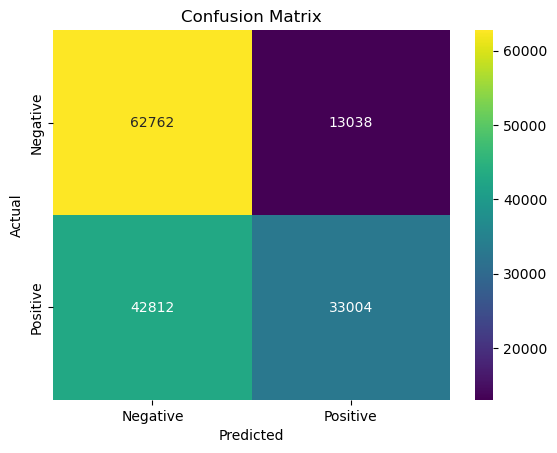

In [58]:
# Create confusion matrix
cm_nn = confusion_matrix(y_test, nn_y_pred)

# Plot confusion matrix
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='viridis', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

This model has essentially given us a similar performance to our MNB model, but with slightly increased performance across the board. All the values are relatively even, and we see a slight performance increase in recall for the positive class, giving us our best performance in that key category yet.

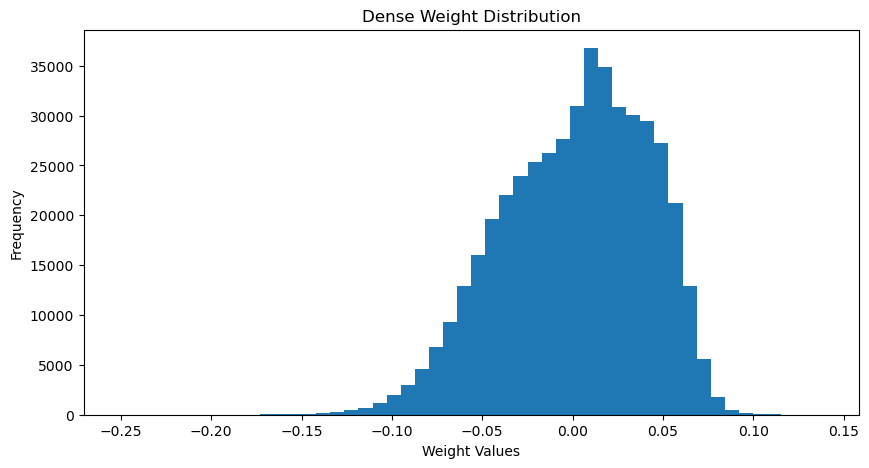

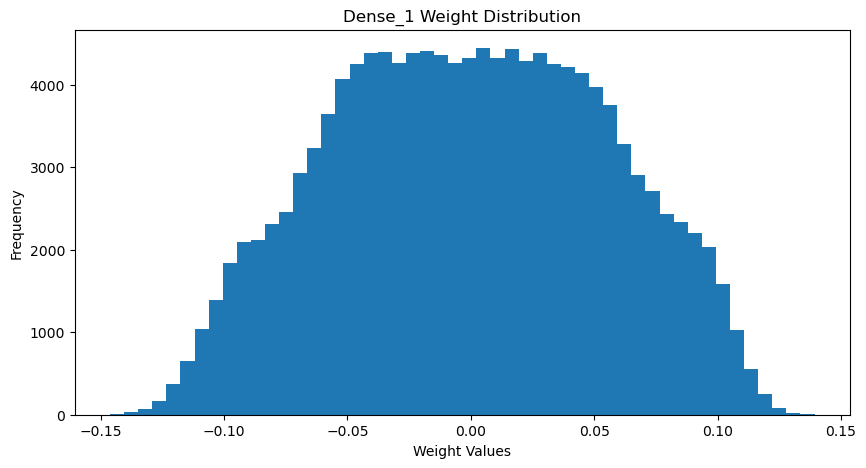

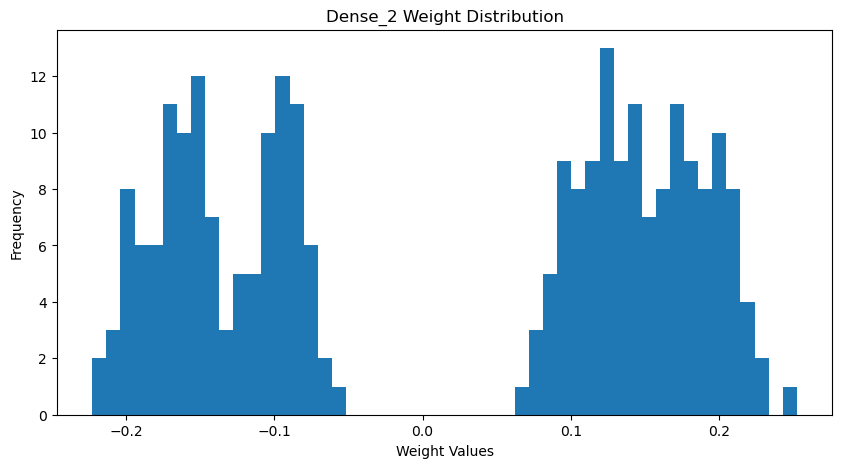

In [59]:
for layer in nn_model_loaded.layers:
    if len(layer.get_weights()) > 0:
        weights = layer.get_weights()[0]  # Get weights of the layer
        plt.figure(figsize=(10, 5))
        plt.title(layer.name.title() + ' Weight Distribution')
        plt.hist(weights.flatten(), bins=50)
        plt.xlabel('Weight Values')
        plt.ylabel('Frequency')
        plt.show()

We can see the model's weight distributions above.

### Word2Vec Embedding

Before we move on to our final model, we will make what's called Word2Vec embeddings. 

Pioneered by engineers at Google in papers like [this](https://arxiv.org/abs/1301.3781v3), the Word2Vec embedding strategy differs from the one we employed before, as it is essentially a mini-neural network itself. In our case, we are using a Continuous Bag-of-Words (CBOW) technique. While normal bag-of-word vectors are sparse and high-dimensional, CBOW vectors are represented in a dense matrix.

So, essentially, we are using this mini-network to predict a word given other words around it. After this process, each word is assigned a vector, this time in a lower-dimensional dense vector space. 

This ends up giving us a vector space where words that are more commonly associated with each other have closer vectors, as opposed to a normal bag of words where such context isn't captured in a much larger and more disparate vector space. This serves to more accurately capture relationships between words and could help give our RNN a boost.

In [60]:
# Tokenize X_train
tokenized_X_train = [doc.split() for doc in X_train]

In [61]:
# Instantiate Word2Vec model and run on X_train
wordvec_model = Word2Vec(sentences=tokenized_X_train, vector_size=100, window=5, min_count=1, workers=4)

In [62]:
# Function to create a document vector by averaging word vectors
def document_vector(wordvec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in wordvec_model.wv]
    if not doc:
        return np.zeros(wordvec_model.vector_size)
    return np.mean(wordvec_model.wv[doc], axis=0)

In [63]:
# Create dense array of vectors
X_train_word2vec = np.array([document_vector(wordvec_model, doc) for doc in tokenized_X_train])

In [64]:
# Check shape of vectors
X_train_word2vec.shape

(707541, 100)

In [65]:
X_val_word2vec = np.array([document_vector(wordvec_model, doc.split()) for doc in X_val])  # Split each document in X_val into words
X_test_word2vec = np.array([document_vector(wordvec_model, doc.split()) for doc in X_test]) # Split each document in X_val into words

In [66]:
# Get correct shapes for model
# X_train_word2vec = X_train_word2vec.reshape((X_train_word2vec.shape[0], X_train_word2vec.shape[1], 1))
# embedding_dim = X_train_word2vec.shape[2]
# max_length = X_train_word2vec.shape[1]

# Define model architecture
# lstm_model = Sequential()
# lstm_model.add(GRU(units=64, input_shape=(max_length, embedding_dim)))
# lstm_model.add(Dense(32, activation='leaky_relu'))
# lstm_model.add(Dense(8, activation='leaky_relu'))
# lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
# lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Get model summary
# lstm_model.summary()

In [67]:
# Fit model on data
# lstm_model.fit(X_train_word2vec, y_train, validation_data=(X_val_word2vec, y_val), epochs=50, batch_size=128)

In [68]:
# Get predictions
# lstm_y_hat = lstm_model.predict(X_test_word2vec)
# y_pred = (lstm_y_hat > 0.5).astype(int)

In [69]:
# Print classification report
# print(classification_report(y_test, y_pred))

In [70]:
# Save model
# lstm_model.save(f'{model_directory}/lstm_model.h5')

In [71]:
# Load model
lstm_model_loaded = load_model('model-weights/lstm_model.h5')

In [72]:
# Plot model structure
plot_model(lstm_model_loaded, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [73]:
# Get predictions
lstm_y_hat = lstm_model_loaded.predict(X_test_word2vec)
lstm_y_pred = (lstm_y_hat > 0.5).astype(int)

4738/4738 [==============================] - 17s 4ms/step


In [74]:
# Print classification report
print(classification_report(y_test, lstm_y_pred))

              precision    recall  f1-score   support

           0       0.51      0.64      0.56     75800
           1       0.51      0.38      0.43     75816

    accuracy                           0.51    151616
   macro avg       0.51      0.51      0.50    151616
weighted avg       0.51      0.51      0.50    151616



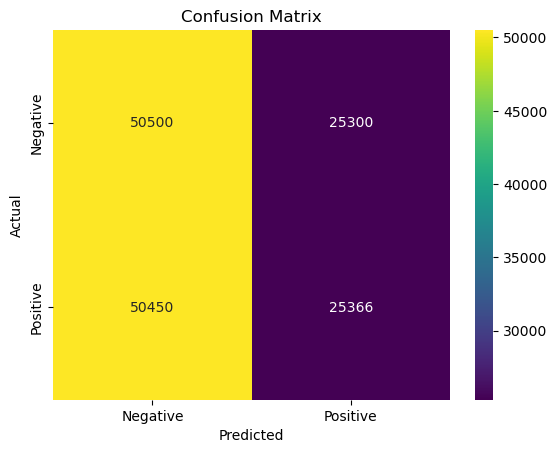

In [75]:
# Create confusion matrix
cm_lstm = confusion_matrix(y_test, lstm_y_pred)

# Plot confusion matrix
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='viridis', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

This model has regressed once again, with performance similar to our XGBoost model in that the RNN exhibits higher recall on the negative class and very low recall on the positive class. Further fine-tuning and much more time could be needed to achieve optimal results with this model.

# Conclusions

While our models did not give us excellent performance on our target metrics, this project has provided us valuable information on the complexities on sarcasm detection, shown us effective and ineffective techniques, and demonstrated the limitations of our dataset.

Our neural network is the most performant and most consistent model in its evaluations. That makes it most viable for implementation.

In their current state, our models would not be able to be used in a production setting. With larger datasets and more resource-intensive preprocessing and training techniques, **I believe that the MLP neural network could be used in a hybrid system, in tandem with existing teams of human moderators.**

More specifically, I recommend that this hybrid approach be leveraged by Reddit for the following tasks:

- **Detecting bullying messages and gathering data on bad actors, leading to bans or suspensions**
- **Detect disturbing content, such as threats, and assess their veracity**

A model with this performance needs work better before it can be used reliably for automated content recommendation. 

In a multi-tiered content moderation system, a less-accurate model that processes quickly could serve as a filter that catches and flags certain content before travels up the chain to either an improved model or a team of humans. In this way, moderators are saved some time and can focus on more complex problems or moderate more content per day, as this model allows them to cast a wide net and whittle down content as they go. This strategy could also work for flagging a wide range of comments and leaving humans to make the final decision.

Even if these strategies are not implemented, we have provided a baseline and proof-of-concept for sarcasm detection over a diverse and difficult range of texts. Further investment in Research and Development, allowing for longer, more complex, and more costly training methods, could yield significant performance gains, especially with a larger dataset that is labeled carefully.

Below I have included some recommendations of next steps that could yield better performance or make implementation more realistic:

## Next Steps

- **Data quality and quantity:** As mentioned in the 'Limitations' section, I believe that some models would show improvement if the data was better labeled and if there was more of it. For use in a real-life setting, I suspect the model would need a much larger vocabulary to be able to keep up with the diversity of speech on a platform like Reddit.
- **Hyperparameter tuning and further optimization:** Some methods could be used to exhaustively search over model hyperparameters to find optimal ones. Given the speed of XGBoost and Naive Bayes, these options could be implemented in the future.
- **Fine-tuning foundational model:** Below my contact information, I have provided some code for initializing and implementing BERT, an extremely large and complex language model deployed by HuggingFace. Fine-tuning this model on our data could yield exceedingly good results, but would take hours or days to train.

Thank you for checking out my work! You can find my contact info and sources below.

## Sources

Mikolov, Tomas et al. (2013). Efficient Estimation of Word Representations in Vector Space. [arXiv:1301.3781](https://arxiv.org/abs/1301.3781v3) [cs.CL].

Schmidt, Robin L. (2019). Recurrent Neural Networks (RNNs): A gentle Introduction and Overview. [arXiv:1912.05911](https://arxiv.org/abs/1912.05911) [cs.LG].

## Contact Information

- Email: apell7591@gmail.com
- Phone: 917-434-6615
- GitHub: [apell7594](https://github.com/apell74)
- LinkedIn: [Adam Pell](www.linkedin.com/in/adam-pell-911868154)

# Training Steps for BERT Below
**Will take hours/days to train!**

## BERT

In [78]:
# Uncomment if you want to use!

# Convert data to correct format
# X_train_bert = X_train.tolist()
# X_val_bert = X_val.tolist()
# X_test_bert = X_test.tolist()

# y_train_bert = y_train.tolist()
# y_val_bert = y_val.tolist()
# y_test_bert = y_test.tolist()

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # Get tokenizer from BERT

# def tokenize_data(texts, tokenizer, max_length=512):
#     return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt") # Tokenizer function

# # Tokenize the data
# train_encodings = tokenize_data(X_train_bert, tokenizer, max_length=512)
# val_encodings = tokenize_data(X_val_bert, tokenizer, max_length=512)
# test_encodings = tokenize_data(X_test_bert, tokenizer, max_length=512)

# # Define the TextDataset class
# class TextDataset(Dataset):
#     def __init__(self, encodings, labels):
#         self.encodings = encodings
#         self.labels = labels

#     def __getitem__(self, idx):
#         item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
#         item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
#         return item

#     def __len__(self):
#         return len(self.labels)

# # Create datasets with tokenized inputs and labels
# train_dataset = TextDataset(train_encodings, y_train_bert)
# val_dataset = TextDataset(val_encodings, y_val_bert)
# test_dataset = TextDataset(test_encodings, y_test_bert)



In [79]:
# Load the pre-trained BERT model
# bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

In [80]:
# training_args = TrainingArguments(
#     output_dir='./results',  # Where to save the model
#     num_train_epochs=3,  # Total number of training epochs
#     per_device_train_batch_size=8,  # Batch size per device during training
#     per_device_eval_batch_size=8,  # Batch size for evaluation
#     warmup_steps=500,  # Number of warmup steps for learning rate scheduler
#     weight_decay=0.01,  # Strength of weight decay
#     logging_dir='./logs',  # Where to store logs
#     evaluation_strategy="epoch",  # Evaluate each epoch
#     logging_steps=10,  # Log and evaluate every 10 steps
# )

# # Create train function
# trainer = Trainer(
#     model=bert_model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset
# )

# # Start training
# trainer.train()

### Download Model Weights

In [2]:
# For downloading model weights. Only use if you want to save new weights!

# FileLinks('model-weights/', result_html_prefix="Click here to download: ")